In [1]:
!pip install -q gwpy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# !pip install rouge_score
# !pip install py7zr
# !pip install transformers
# !pip install datasets
# !pip install rouge
from typing import List
import os
import json
import ast
import pandas as pd
import csv
import argparse
import pickle
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, load_from_disk
import numpy as np
from datasets import load_dataset, load_metric, load_from_disk
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from rouge import Rouge
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nahyun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nahyun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_parsed = pd.read_csv('./Results_csv/twcs_train.csv')

input_len = []
target_len = []

for i in range(len(train_parsed)):
    dialog_len = len(train_parsed.iloc[i]['dialog'])
    summary_len = len(train_parsed.iloc[i]['summary'])
    input_len.append(dialog_len)
    target_len.append(summary_len)

print(sum(input_len)/len(input_len))
print(sum(target_len)/len(target_len))


617.6221945137157
201.90274314214463


In [3]:
max_input = 600
max_target = 200
batch_size = 100
# model_name= "philschmid/distilbart-cnn-12-6-samsum
model_name = "linydub/bart-large-samsum"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
def preprocess_data(data_to_process):
  #get all the dialogues  
  data_to_process['dialog'] = data_to_process['dialog'].astype('string')
  data_to_process['summary'] = data_to_process['summary'].astype('string')
  list_summary = list(data_to_process['summary'])
  inputs = [dialogue for dialogue in data_to_process['dialog']]
  #tokenize the dialogues
  model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(list_summary, max_length=max_target, padding='max_length', truncation=True)
  #set labels
  'id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'
  model_inputs['labels'] = targets['input_ids']

  #return the tokenized data
  #input_ids, attention_mask and labels
  results = []
  for i in range (len(list(data_to_process['dialog']))):
    dic = {'dialogue':list(data_to_process['dialog'])[i], 'summary':list(data_to_process['summary'])[i],'input_ids':model_inputs['input_ids'][i], 'attention_mask':model_inputs['attention_mask'][i], 'labels':model_inputs['labels'][i]}
    results.append(dic)
  return results



In [5]:
train_parsed = pd.read_csv('./Results_csv/twcs_train.csv')
valid_parsed = pd.read_csv('./Results_csv/twcs_val.csv')
test_parsed = pd.read_csv('./Results_csv/twcs_test.csv')

preprocessed_train_data = preprocess_data(train_parsed)
preprocessed_valid_data = preprocess_data(valid_parsed)

C:\Users\nahyun\anaconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [6]:
# model_name="philschmid/distilbart-cnn-12-6-samsum"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
metric = load_metric('rouge')
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)
def compute_rouge(pred):
  predictions, labels = pred
  #decode the predictions
  decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #compute results
  res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
  #get %
  res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

  pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  res['gen_len'] = np.mean(pred_lens)

  return {k: round(v, 4) for k, v in res.items()}

C:\Users\nahyun\AppData\Local\Temp\ipykernel_5296\3065557357.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')


## CALLBACK

In [7]:
import os
from transformers.integrations import TrainerCallback, is_tensorboard_available

def custom_rewrite_logs(d, mode):
    new_d = {}
    eval_prefix = "eval_"
    eval_prefix_len = len(eval_prefix)
    test_prefix = "test_"
    test_prefix_len = len(test_prefix)
    for k, v in d.items():
        if mode == 'eval' and k.startswith(eval_prefix):
            if k[eval_prefix_len:] == 'loss':
                new_d["combined/" + k[eval_prefix_len:]] = v
        elif mode == 'test' and k.startswith(test_prefix):
            if k[test_prefix_len:] == 'loss':
                new_d["combined/" + k[test_prefix_len:]] = v
        elif mode == 'train':
            if k == 'loss':
                new_d["combined/" + k] = v
    return new_d


class CombinedTensorBoardCallback(TrainerCallback):
    """
    A [`TrainerCallback`] that sends the logs to [TensorBoard](https://www.tensorflow.org/tensorboard).
    Args:
        tb_writer (`SummaryWriter`, *optional*):
            The writer to use. Will instantiate one if not set.
    """

    def __init__(self, tb_writers=None):
        has_tensorboard = is_tensorboard_available()
        if not has_tensorboard:
            raise RuntimeError(
                "TensorBoardCallback requires tensorboard to be installed. Either update your PyTorch version or"
                " install tensorboardX."
            )
        if has_tensorboard:
            try:
                from torch.utils.tensorboard import SummaryWriter  # noqa: F401

                self._SummaryWriter = SummaryWriter
            except ImportError:
                try:
                    from tensorboardX import SummaryWriter

                    self._SummaryWriter = SummaryWriter
                except ImportError:
                    self._SummaryWriter = None
        else:
            self._SummaryWriter = None
        self.tb_writers = tb_writers

    def _init_summary_writer(self, args, log_dir=None):
        log_dir = log_dir or args.logging_dir
        if self._SummaryWriter is not None:
            self.tb_writers = dict(train=self._SummaryWriter(log_dir=os.path.join(log_dir, 'train')),
                                   eval=self._SummaryWriter(log_dir=os.path.join(log_dir, 'eval')))

    def on_train_begin(self, args, state, control, **kwargs):
        if not state.is_world_process_zero:
            return

        log_dir = None

        if state.is_hyper_param_search:
            trial_name = state.trial_name
            if trial_name is not None:
                log_dir = os.path.join(args.logging_dir, trial_name)

        if self.tb_writers is None:
            self._init_summary_writer(args, log_dir)

        for k, tbw in self.tb_writers.items():
            tbw.add_text("args", args.to_json_string())
            if "model" in kwargs:
                model = kwargs["model"]
                if hasattr(model, "config") and model.config is not None:
                    model_config_json = model.config.to_json_string()
                    tbw.add_text("model_config", model_config_json)
            # Version of TensorBoard coming from tensorboardX does not have this method.
            if hasattr(tbw, "add_hparams"):
                tbw.add_hparams(args.to_sanitized_dict(), metric_dict={})

    def on_log(self, args, state, control, logs=None, **kwargs):
        if not state.is_world_process_zero:
            return

        if self.tb_writers is None:
            self._init_summary_writer(args)

        for tbk, tbw in self.tb_writers.items():
            logs_new = custom_rewrite_logs(logs, mode=tbk)
            for k, v in logs_new.items():
                if isinstance(v, (int, float)):
                    tbw.add_scalar(k, v, state.global_step)
                else:
                    logger.warning(
                        "Trainer is attempting to log a value of "
                        f'"{v}" of type {type(v)} for key "{k}" as a scalar. '
                        "This invocation of Tensorboard's writer.add_scalar() "
                        "is incorrect so we dropped this attribute."
                    )
            tbw.flush()

    def on_train_end(self, args, state, control, **kwargs):
        for tbw in self.tb_writers.values():
            tbw.close()
        self.tb_writers = None


In [8]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience= 3, 
                                    early_stopping_threshold= 0.001)

## Train

In [11]:
output_dir = './training-log/bart/'

In [16]:
args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy='steps',
    learning_rate=1e-6,
    auto_find_batch_size= True,
    per_device_train_batch_size=7,
    per_device_eval_batch_size=7,
    gradient_accumulation_steps=2,
    weight_decay=0.001,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True,
    overwrite_output_dir= True,
    load_best_model_at_end = True,
    save_strategy='steps'
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=preprocessed_train_data,
    eval_dataset=preprocessed_valid_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge,
    callbacks=[CombinedTensorBoardCallback, early_stopping]
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2406
  Num Epochs = 10
  Instantaneous batch size per device = 7
  Total train batch size (w. parallel, distributed & accumulation) = 14
  Gradient Accumulation steps = 2
  Total optimization steps = 1720
  Number of trainable parameters = 406291456
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: dialogue, summary. If dialogue, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2406
  Num Epochs = 10
  Instantaneous batch size per device = 7
  Total train batch size (w. parallel, distributed & accumulation) = 14
  Gradient Accumulation steps = 2
  Total optimization steps = 4010
  Number of trainable parameters = 406291456
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have

Step,Training Loss,Validation Loss


***** Running training *****
  Num examples = 2406
  Num Epochs = 10
  Instantaneous batch size per device = 7
  Total train batch size (w. parallel, distributed & accumulation) = 14
  Gradient Accumulation steps = 2
  Total optimization steps = 12030
  Number of trainable parameters = 406291456
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: dialogue, summary. If dialogue, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss


In [ ]:
trainer.save_model(output_dir)

In [12]:
%load_ext tensorboard
%tensorboard --logdir bart_2/runs

In [13]:
predicted_sum = []
for test_dialog in test_parsed['dialog']:
  model_inputs = tokenizer(test_dialog,  max_length=max_input, padding='max_length', truncation=True)
  raw_pred, _, _ = trainer.predict([model_inputs])
  predicted_sum.append(tokenizer.decode(raw_pred[0]))

***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


In [14]:
cleaned_data = []
for summary in predicted_sum:
  summary= summary.replace('</s>', '')
  summary= summary.replace('<s>', '')
  summary= summary.replace('<pad>', '')
  cleaned_data.append(summary)

In [15]:
test_parsed['finetuned_predicted'] = cleaned_data

In [16]:
summaries = list(test_parsed['summary'])

rouge = Rouge()
rouge.get_scores(list(test_parsed['finetuned_predicted']), summaries, avg=True)

{'rouge-1': {'r': 0.48203467587415233,
  'p': 0.44523305117902395,
  'f': 0.4523874960578098},
 'rouge-2': {'r': 0.23261077083214846,
  'p': 0.2249690564163938,
  'f': 0.22176661525101474},
 'rouge-l': {'r': 0.4554160580998408,
  'p': 0.4212568126352789,
  'f': 0.4276624104205268}}

In [18]:
test_parsed.to_csv("predicted_with_bart_2.csv")

In [19]:
def generation_Rouge_Scores(X, Y):  
  rouge = Rouge()
  return rouge.get_scores(X, Y)

def get_rouge1_rouge2_scores_for_bxplot(test_parsed):
  Rouge_1_f1scores_list = []
  Rouge_2_f1scores_list = []
  Rouge_1_precision_list = []
  Rouge_2_precision_list = []
  Rouge_1_recall_list = []
  Rouge_2_recall_list = []
  for i in range(len(test_parsed)):
    X = test_parsed['summary'][i]
    Y = test_parsed['finetuned_predicted'][i]
    get_rouge_scores = generation_Rouge_Scores(X,Y)
    Rouge_1_f1scores = get_rouge_scores[0]['rouge-1']['f']
    Rouge_2_f1scores = get_rouge_scores[0]['rouge-2']['f']

    Rouge_1_f1scores_list.append(Rouge_1_f1scores)
    Rouge_2_f1scores_list.append(Rouge_2_f1scores)

    Rouge_1_precision = get_rouge_scores[0]['rouge-1']['p']
    Rouge_2_precision = get_rouge_scores[0]['rouge-2']['p']

    Rouge_1_precision_list.append(Rouge_1_precision)
    Rouge_2_precision_list.append(Rouge_2_precision)

    Rouge_1_recall = get_rouge_scores[0]['rouge-1']['r']
    Rouge_2_recall = get_rouge_scores[0]['rouge-2']['r']

    Rouge_1_recall_list.append(Rouge_1_recall)
    Rouge_2_recall_list.append(Rouge_2_recall)
  return Rouge_1_f1scores_list, Rouge_2_f1scores_list

In [20]:
Rouge_1_f1scores_finetuned_CNN, Rouge_2_f1scores_finetuned_CNN = get_rouge1_rouge2_scores_for_bxplot(test_parsed)
print("Max for Rouge_1 f1 scores    : ", np.max(Rouge_1_f1scores_finetuned_CNN))
print("Min for Rouge_1 f1 scores    : ", np.min(Rouge_1_f1scores_finetuned_CNN))
print("Mean for Rouge_1 f1 scores   : ", np.mean(Rouge_1_f1scores_finetuned_CNN))
print("Median for Rouge_1 f1 scores : ", np.median(Rouge_1_f1scores_finetuned_CNN))

Max for Rouge_1 f1 scores    :  0.8615384565680474
Min for Rouge_1 f1 scores    :  0.1290322534859523
Mean for Rouge_1 f1 scores   :  0.4523874960578098
Median for Rouge_1 f1 scores :  0.44897958685547695


<AxesSubplot: title={'center': 'Rouge 1 f1 scores for cnn-12-6-samsum model'}>

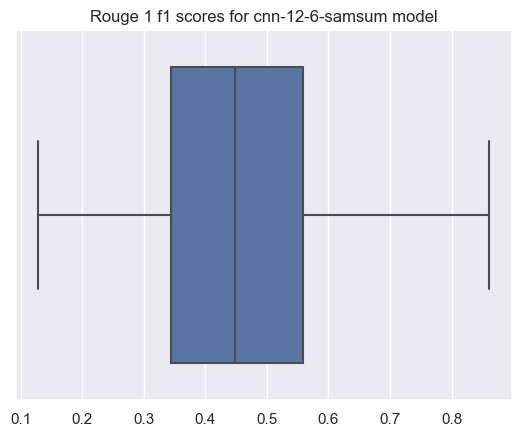

In [21]:
sns.set(style="darkgrid")
plt.title("Rouge 1 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_1_f1scores_finetuned_CNN)

In [22]:
print("Max for Rouge_2 f1 scores    : ", np.max(Rouge_2_f1scores_finetuned_CNN))
print("Min for Rouge_2 f1 scores    : ", np.min(Rouge_2_f1scores_finetuned_CNN))
print("Mean for Rouge_2 f1 scores   : ", np.mean(Rouge_2_f1scores_finetuned_CNN))
print("Median for Rouge_2 f1 scores : ", np.median(Rouge_2_f1scores_finetuned_CNN))

Max for Rouge_2 f1 scores    :  0.7499999950195314
Min for Rouge_2 f1 scores    :  0.0
Mean for Rouge_2 f1 scores   :  0.2217666152510147
Median for Rouge_2 f1 scores :  0.19780219324236215


<AxesSubplot: title={'center': 'Rouge 2 f1 scores for cnn-12-6-samsum model'}>

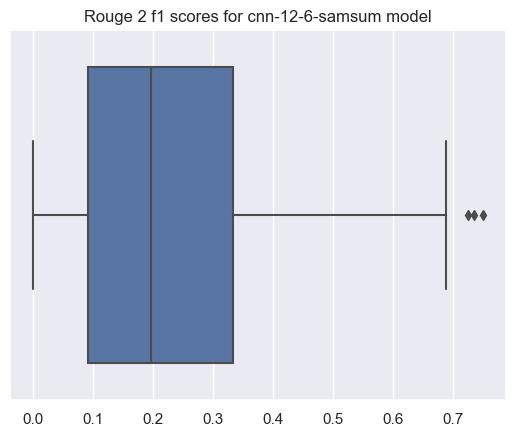

In [23]:
sns.set(style="darkgrid")
plt.title("Rouge 2 f1 scores for cnn-12-6-samsum model")
sns.boxplot(x=Rouge_2_f1scores_finetuned_CNN)